<a href="https://colab.research.google.com/github/WoobeenJeong/bioinfo1_jwb/blob/main/Project_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1) Data mounting**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2) Environment setting**

In [ ]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

In [ ]:
!conda install -y bedtools bioawk samtools

**3) Data loading & check**

In [ ]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


In [ ]:
!ls -al /content/drive/MyDrive/binfo1-work/

In [ ]:
!md5sum /content/drive/MyDrive/binfo1-work/*

**4) Background setting**

In [4]:
%cd /content/drive/MyDrive/binfo1-work
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter

/content/drive/MyDrive/binfo1-work


**5) Target region on CLIP-seq using gencode.gtf**

먼저 GTF파일은 genecode로부터 M32버전이 (2023.02월에) 나왔으며  
M32(GRCm39) Refseq 자료 중 chr9에 대해 확인 할 것  
NCBI RefSeq에서도 Mus musculus strain C57BL/6J chromosome 9, GRCm39 존재

1) C=Shannon’s entrophy를 CRES: Crosslinking-induced reverse transcription error score로 가져감  
2) 이때, insertion은 무시 substitution과 deletion고려  
3) FDR은 permutation으로 구함   
4) Read는 rRNA,tRNA,adapte제외하고 GSNAP의 Refseq에 align  
5) 이를 바탕으로, 먼저 CRES(0.8) 상 low depth positio이 130 reads 이하  
6) LOESS smoothing (regression) a=0.5사용 medium depth positon 250 read이하  
7) FDR(0.001)상 high depth position >250 read 사용  

In [ ]:
!gzip -d gencode.vM32.annotation.gtf.gz

gzip: gencode.vM32.annotation.gtf.gz: No such file or directory


In [ ]:
!grep 'chr9' gencode.vM32.annotation.gtf > gencode.vM32.chr9.gtf

In [ ]:
!head gencode.vM32.chr9.gtf

In [ ]:
!awk -F'\t' '{if ($3 == "gene") print $4}' gencode.vM32.chr9.gtf | sort -n | head -n 1
!awk -F'\t' '{if ($3 == "gene") print $5}' gencode.vM32.chr9.gtf | sort -n | tail -n 1

3038669
124252776


In [5]:
!samtools view -b -o CLIP-let7g.bam CLIP-35L33G.bam chr9:3038669-124252776
!samtools view CLIP-let7g.bam | wc -l

1696165


In [6]:
!samtools index CLIP-let7g.bam

In [7]:
!samtools view -F 16 CLIP-let7g.bam | wc -l

905001


(+)stand만 추출, 절반이 사라짐

In [9]:
!samtools view -b -F 0x10 -o forward-CLIP-let7g.bam CLIP-let7g.bam

In [ ]:
!samtools view -f 16 forward-CLIP-let7g.bam  | wc -l

0


In [10]:
!samtools view -F 16 forward-CLIP-let7g.bam  | wc -l

905001


QC는 상관없을 것으로 생각되나, secondary와 supplimentary read는 제거해야함 = secondary는 하나의 서열이 다른 곳에도 mapping될 수 있음을 고려, 

In [ ]:
!samtools flagstat forward-CLIP-let7g.bam | head

905001 + 0 in total (QC-passed reads + QC-failed reads)
339889 + 0 secondary
189 + 0 supplementary
0 + 0 duplicates
905001 + 0 mapped (100.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped


In [11]:
!samtools view -b -F 0x900 -o first-forward-CLIP-let7g.bam forward-CLIP-let7g.bam

In [12]:
!samtools view -F 16 first-forward-CLIP-let7g.bam  | wc -l

564923


estimate가 0.001 이었으니, MAPQ가 30이다.

In [102]:
!samtools view -q 30 -b first-forward-CLIP-let7g.bam -o check-CLIP-let7g.bam
!wc -l check-CLIP-let7g.bam

73508 check-CLIP-let7g.bam


In [103]:
!samtools mpileup check-CLIP-let7g.bam 2>/dev/null > check-CLIP-let7g.pileup
!wc -l check-CLIP-let7g.pileup

18224608 check-CLIP-let7g.pileup


In [104]:
!awk '$2 >= 3038669 && $2 <= 124252714 { print $0; }' check-CLIP-let7g.pileup > check-CLIP-let7g-gene.pileup
!tail -n 2 check-CLIP-let7g-gene.pileup

chr9	124220663	N	1	C	2
chr9	124220664	N	1	T$	2


In [105]:
pileup = pd.read_csv('check-CLIP-let7g-gene.pileup', sep='\t', names=['chrom', 'pos', 'ref', 'count', 'basereads', 'quals'])
pileup.tail()

,chrom,pos,ref,count,basereads,quals
18224603,chr9,124220660,N,1,C,@
18224604,chr9,124220661,N,1,C,C
18224605,chr9,124220662,N,1,C,C
18224606,chr9,124220663,N,1,C,2
18224607,chr9,124220664,N,1,T$,2


count의 개수가 최대 / 최소 얼마이고 볼 만한 수준인지 확인

In [106]:
len(np.unique(pileup['count']))

1740

In [107]:
pileup['count'].describe()

count    1.822461e+07
mean     1.073809e+01
std      4.920374e+01
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      7.994000e+03
Name: count, dtype: float64

위를 보면 알수 있듯이 한 75%까지는 10개정도만 count되어 있는데, 무려 7993 read가 count되는 경우도 있음.  
이경우는 좀 궁금하긴 하다만, 너무 크기 때문에, threshold <=50 reads로 두고 진행   
(Shannon에서 depth 50으로 했으므로)

In [108]:
f50pileup = pileup[pileup['count'] > 50]

In [109]:
len(np.unique(f50pileup['count']))

1689

In [110]:
len(np.unique(f50pileup['pos']))

534478

In [111]:
f50pileup['count'].describe()

count    534478.000000
mean        140.538063
std         251.364587
min          51.000000
25%          58.000000
50%          72.000000
75%         108.000000
max        7994.000000
Name: count, dtype: float64

In [112]:
max(f50pileup['pos']),min(f50pileup['pos'])

(123421315, 3359542)

match와 substitution, deletion을 사용할 것이므로, 나머지에 해당하는 tag들은 제거.  
**여기서 Deletion은 포함하는 경우를 고려하는 것을 고민할 것**

In [114]:
toremove = re.compile(r'[<>$*#+-]|\^.')
f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))

<ipython-input-114-854502dbb2ce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup.loc[:, 'matches'] = f50pileup['basereads'].apply(lambda x: toremove.sub('', x))


In [115]:
f50pileup[['chrom', 'pos', 'matches']].head()

,chrom,pos,matches
21616,chr9,3359542,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21617,chr9,3359543,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21618,chr9,3359544,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
21619,chr9,3359545,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...
21620,chr9,3359546,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...


Deletion상관 없이 Insertion하고 Hard-clipped read만 제외

In [ ]:
#f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c != 'H' and c != 'I']))
#f50pileup.head()

In [40]:
import itertools

column = f50pileup['matches']
components = column.str.findall('[A-Za-z]')
ATGCs = list(itertools.chain(*components))
set(ATGCs)

{'A', 'C', 'G', 'N', 'T'}

In [314]:
f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))
f50pileup.head()

<ipython-input-314-dc38196e0fd8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f50pileup['base_count'] = f50pileup['matches'].apply(lambda x: len([c for c in x if c.upper() in ('A', 'T', 'G', 'C')]))


,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


In [ ]:
np.unique(f50pileup['matches'])

In [316]:
np.unique(f50pileup['base_count'])

array([   0,    1,    2, ..., 7989, 7990, 7994])

Colab RAM사용 제한 상, 데이터가 날라가는 것을 방지하기 위해 일단 결과 csv 저장

In [317]:
f50pileup.to_csv('f50pileup.csv', index=True)

In [319]:
f50pileup.head()

,chrom,pos,ref,count,basereads,quals,matches,base_count
21616,chr9,3359542,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,HDEIHIIGIIIHHIIGAIIIGIBGIHBFGIHE?GIGIHGGHHIBII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21617,chr9,3359543,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IGEIHFG@IIIHHHIGFHIIEIBHIH;GGIHH=GIEIHIGHHIGII...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21618,chr9,3359544,N,51,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHBIHIIDHGIGHIIIDIIIDH0HH?DEHFHBBGIGIHIGHHDAII...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,51
21619,chr9,3359545,N,51,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IH8IHIIEIGIGHIIFFIIIGI=HIHDGGIHI;GHIIGHGHHI4DI...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,51
21620,chr9,3359546,N,51,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,IHEIHHIEIGGDHIIDHIIIGI7HIH>GHIHI<GIGIFIGDHFCII...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,51


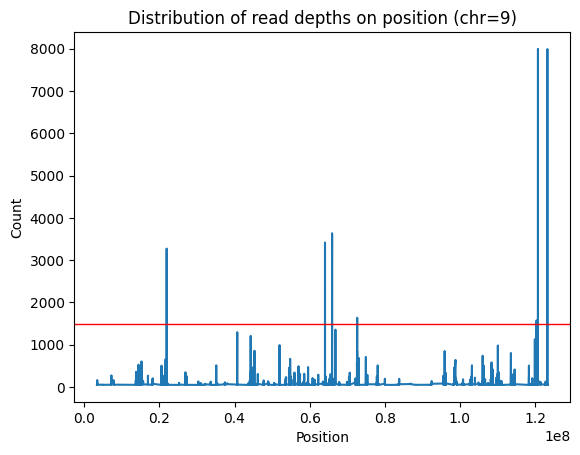

In [344]:
x = f50pileup['pos']
y = f50pileup['count']

plt.plot(x, y)
plt.xlabel('Position')
plt.ylabel('Count')
plt.title('Distribution of read depths on position (chr=9)')
plt.axhline(1500, c='red', linewidth=1)
plt.show()

In [343]:
pup = f50pileup[f50pileup['base_count']>1500]

In [345]:
pup['base_count'].head()

2419292    3230
2419293    3227
2419294    3243
2419295    3245
2419296    3248
Name: base_count, dtype: int64

In [346]:
pup['matches'].apply(len)

2419292     3230
2419293     3227
2419294     3243
2419295     3245
2419296     3248
            ... 
17967218    3217
17967219    2958
17967220    2546
17967221    2438
17967222    1548
Name: matches, Length: 675, dtype: int64

In [347]:
pup['nonzero'] = pup['base_count']/pup['basereads'].apply(len)
pup.head()

<ipython-input-347-ef3998149eec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['nonzero'] = pup['base_count']/pup['basereads'].apply(len)


,chrom,pos,ref,count,basereads,quals,matches,base_count,nonzero
2419292,chr9,21923376,N,3230,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IHEGIEGDIIIBGI8IGHH>B=IIG@IHIGH@HIGEGEIEBIHD=G...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,3230,0.480941
2419293,chr9,21923377,N,3227,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHGGHBGHIII=GI@IGII>DDIGGGIHHGH@EGD@GBIDGII<BD...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3227,0.998144
2419294,chr9,21923378,N,3243,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHEGIGGIIII=GI@IBHI>DEIIGGIHIGHCHIGBE@IEGII:@G...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3243,0.995091
2419295,chr9,21923379,N,3245,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,DH@GGGEIIII=GI@IBHIBBEIIGGFHIEH:GIGEGBIEGII:BG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3245,0.998154
2419296,chr9,21923380,N,3248,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IHEDDGGGHDI8BI@GGGBA@3IGGGIHGGHBHIG@D4HGDHIDED...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,3248,0.992059


In [365]:
pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])
pup.head()

<ipython-input-365-fbb7882d73db>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup['shannon'] = -pup['nonzero']*np.log2(pup['nonzero'])*2


,chrom,pos,ref,count,basereads,quals,matches,base_count,nonzero,shannon
2419292,chr9,21923376,N,3230,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IHEGIEGDIIIBGI8IGHH>B=IIG@IHIGH@HIGEGEIEBIHD=G...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,3230,0.480941,1.015813
2419293,chr9,21923377,N,3227,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHGGHBGHIII=GI@IGII>DDIGGGIHHGH@EGD@GBIDGII<BD...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3227,0.998144,0.005350
2419294,chr9,21923378,N,3243,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IHEGIGGIIII=GI@IBHI>DEIIGGIHIGHCHIGBE@IEGII:@G...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3243,0.995091,0.014131
2419295,chr9,21923379,N,3245,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,DH@GGGEIIII=GI@IBHIBBEIIGGFHIEH:GIGEGBIEGII:BG...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,3245,0.998154,0.005320
2419296,chr9,21923380,N,3248,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,IHEDDGGGHDI8BI@GGGBA@3IGGGIHGGHBHIG@D4HGDHIDED...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,3248,0.992059,0.022823


In [366]:
len(np.unique(pup['pos']))

675

In [367]:
pup['shannon'].describe()

count    675.000000
mean       0.139754
std        0.221821
min       -0.000000
25%        0.011000
50%        0.047356
75%        0.154446
max        1.061449
Name: shannon, dtype: float64

In [368]:
grouped = pup.groupby('pos')['shannon'].sum().reset_index() 

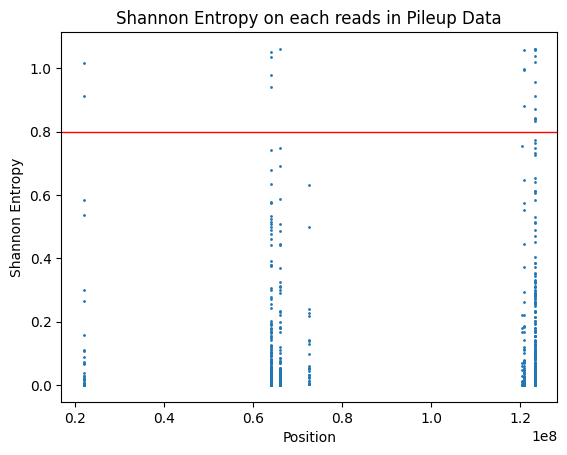

In [369]:
plt.scatter(grouped['pos'], grouped['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy on each reads in Pileup Data')
plt.axhline(0.8, c='red', linewidth=1)
plt.show()

In [353]:
import collections
from scipy.stats import entropy

def shannon(seq):
    tmp = collections.Counter([tmp_base for tmp_base in seq])
    dist = [x/sum(tmp.values()) for x in tmp.values()]
    result = entropy(dist, base=2)
    return result

<ipython-input-354-84df57a27493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))


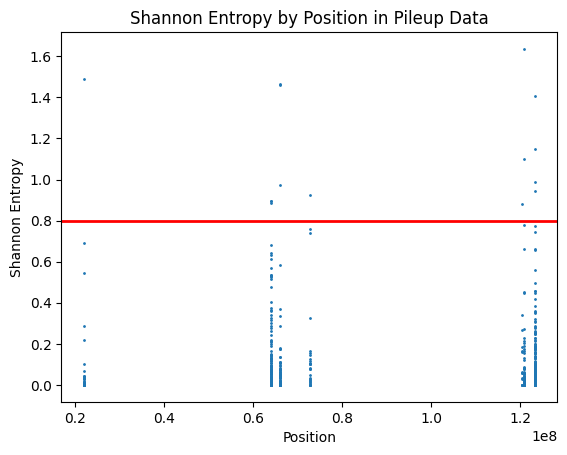

In [354]:
pup2 = pup
pup2['shannon'] = pup2['matches'].map(lambda x : shannon(x))
plt.scatter(pup2['pos'], pup2['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.axhline(0.8, c='red', linewidth=2)
plt.show()

In [370]:
subpup = pup[(pup['shannon'] > 0.8) & (pup['pos'] > 1.0e8)]

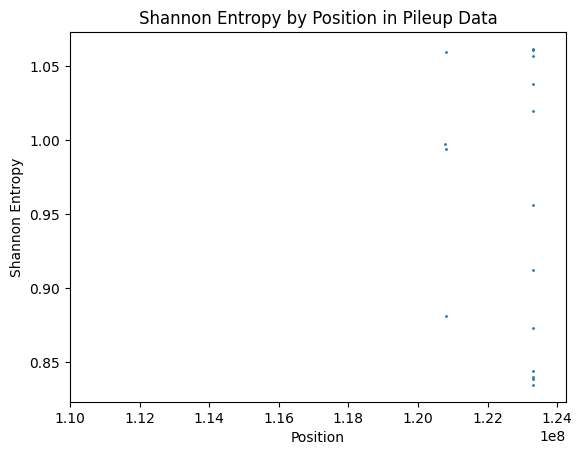

In [378]:
plt.scatter(subpup['pos'], subpup['shannon'],s=1)
plt.xlabel('Position')
plt.ylabel('Shannon Entropy')
plt.title('Shannon Entropy by Position in Pileup Data')
plt.xlim(1.1e8,124252714)
plt.show()

In [380]:
subpup

,chrom,pos,ref,count,basereads,quals,matches,base_count,nonzero,shannon
17523922,chr9,120788886,N,2217,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,II?@=EHHED?HHIBBHGIIIIHIG?BEIHHIIHIGIIIDFG<IIH...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2212,0.502842,0.997461
17524432,chr9,120789396,N,7955,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,IG=DIIHBGIIGI;GI2HIII>HDEDGIDGIGGGHIIEIGHGHDIH...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,7955,0.344060,1.059201
17524467,chr9,120789431,N,5121,TTTT$T$T$T$TT$T$T$T$T$T$T$T$TTT$TTT$TT$TT$T$TT...,IH6IIGB?9IIGIGEEHEHDDGIE?DGIGIIII?HIIGGGGGIIIH...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,5121,0.602187,0.881260
17524468,chr9,120789432,N,1760,C$C$C$C$C$CC$C$C$C$C$C$C$C$C$C$C$C$CC$C$C$C$C$...,IH=BI=FDI:IGIGIIIIGBIGGIIIGIFH8I<IIGG<DHHIEGIB...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,1760,0.506329,0.994281
17966887,chr9,123290888,N,7432,>>>>>>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA-1N...,CEF>9EIHDG;B?GGH@BHDIIIHGGHIIIIDI>GH@IG<@EI<@I...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA1NAAAAAA1...,7401,0.356984,1.061006
17966937,chr9,123290938,N,2090,>>>>>>C$C$C$C$C$C$C$C$C$CC$CC$C$CC$C$C$C$C$C$C...,CEF>9EHEAI:IE?EIFGIDGHGE@;HBBEBGGHE.HBGGHH@GDC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,2080,0.627073,0.844410
17966970,chr9,123290971,N,2603,>>>>>>AAAAAA$AAAAAAAAAAAA$AAAAAA$AAAAAAAAAAA$A...,CEF>9EHHIGGI<GIIEGIGIIGIGIEHGEIEIHFIBBDIIGIFGI...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2594,0.447782,1.038077
17966972,chr9,123290973,N,3831,>>>>>>GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,CEF>9EDG.EGICDI>IHGD>DGI8GFH7@G>H8EIBG8BHBFIGG...,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,3814,0.607809,0.873191
17967018,chr9,123291019,N,2581,>>>>>>TT$TTTTTTT$TTT$TTT$T$TT$TTTTTTTTTTTTTT$T...,CEF>9E>AHEHEBEFGDEDIIGIDGGHEFIAIF0IDHG>HD7FBEH...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,2574,0.633210,0.834879
17967024,chr9,123291025,N,2477,>>>>>>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,CEF>9EBGGIFGGGAIEHGEGIEEGFGGGHIGHBIHCI;HHGHBHH...,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2470,0.476190,1.019418
